In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
df_forward = pd.read_csv('exchange_rates.csv')
ir = pd.read_csv('adjusted_ir.csv')
ir_dates = list(ir['DATE'])
tickers = list(df_forward.columns[1:])
dates = list(df_forward['Date'])
trading_days = dates[dates.index('3/18/2016'):dates.index('3/1/2021')]

In [4]:
def get_param(date, currency, length):
    d_index = dates.index(date)
    prices = list(df_forward[currency][d_index - length - 1 : d_index])
    returns = np.array([prices[i] / prices[i-1] - 1 for i in range(1,length+1)])
    return np.mean(returns), np.std(returns)

In [5]:
def cal_ret(prices):
    rets = prices[1:] / prices[0:len(prices) - 1] -1
    return rets

In [6]:
def calculate_RSI(prices, periods=14):
    length = len(prices)
    all_rsi = [np.nan] * length
    if length <= periods:
        return all_rsi
    up_avg, down_avg = 0, 0

    first_t = prices[:periods + 1]
    for i in range(1, len(first_t)):
        if first_t[i] >= first_t[i - 1]:
            up_avg += first_t[i] - first_t[i - 1]
        else:
            down_avg += first_t[i - 1] - first_t[i]
    up_avg = up_avg / periods
    down_avg = down_avg / periods
    rs = up_avg / down_avg
    all_rsi[periods] = 100 - 100 / (1 + rs)

    for j in range(periods + 1, length):
        up, down = 0, 0
        if prices[j] >= prices[j - 1]:
            up = prices[j] - prices[j - 1]
            down = 0
        else:
            up = 0
            down = prices[j - 1] - prices[j]
        up_avg = (up_avg * (periods - 1) + up) / periods
        down_avg = (down_avg * (periods - 1) + down) / periods
        rs = up_avg / down_avg
        all_rsi[j] = 100 - 100 / (1 + rs)
    return all_rsi[periods:]

In [44]:
all_trades = {}
for j in range(len(trading_days)):
    day = trading_days[j]
    di = dates.index(day)
    prev = dates[di - 1]
    temp = df_forward[di-50:di]
    scores = [calculate_RSI(np.array(temp[tickers[i]]),5)[-1] for i in range(len(tickers))]
    rets = [cal_ret(np.array(temp[tickers[i]][-5:]))[-1] for i in range(len(tickers))]

    ranking = list(np.argsort(scores))
    
    if np.max(rets) <= 0:
        sel =  ['Short', tickers[ranking[-2]], tickers[ranking[-1]]]
        all_trades[day] = sel
        continue
    
    best, snd, worst = ranking[0], ranking[1], ranking[-1]
    

    sel = [tickers[best], tickers[snd], tickers[worst]]
    all_trades[day] = sel
    
    


C:\Users\21130\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in double_scalars
  app.launch_new_instance()
C:\Users\21130\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\21130\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
C:\Users\21130\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars


Total amount after 5 year:  138701647.84042814


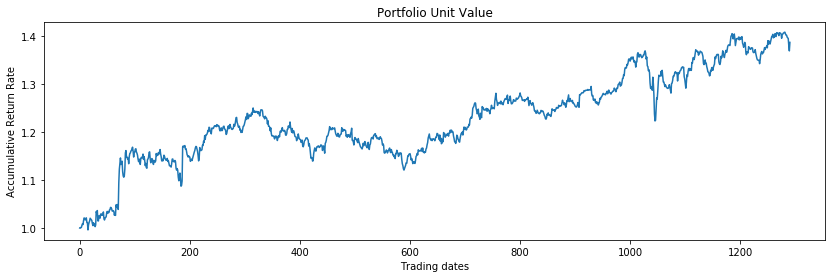

In [45]:
capital = 100000000
pnl = []
accumulative = [capital]
for i in range(len(trading_days)):
    date = trading_days[i]
    prev_date = trading_days[i-1]
    if i == 0:
        pnl.append(0)
        continue
    selections = all_trades[prev_date]
    if 'Short' in selections:
        prevs, currs = df_forward.iloc[dates.index(prev_date)], df_forward.iloc[dates.index(date)]
        yesterday = [prevs[selections[-1]], prevs[selections[1]],]
        today = [currs[selections[-1]], currs[selections[1]]]
        r1 = -0.5*capital / yesterday[0] * (today[0]-yesterday[0]) 
        r2 = -0.5*capital / yesterday[1] * (today[1]-yesterday[1])
        r3 = 0
        total = r1 + r2 + r3
        pnl.append(total)
        capital += total
        accumulative.append(capital)
        continue
        
    prevs, currs = df_forward.iloc[dates.index(prev_date)], df_forward.iloc[dates.index(date)]
    yesterday = [prevs[selections[0]], prevs[selections[1]], prevs[selections[-1]]]
    today = [currs[selections[0]], currs[selections[1]], currs[selections[-1]]]

    r1 = 0.5*capital / yesterday[0] * (today[0]-yesterday[0]) 

    r2 = 0.5*capital / yesterday[1] * (today[1]-yesterday[1])

    r3 = -capital / yesterday[-1] * (today[-1]-yesterday[-1])
    total = r1 + r2 + r3
    pnl.append(total)
    capital += total
    accumulative.append(capital)

print('Total amount after 5 year: ', capital)

plt.title('Portfolio Unit Value')
plt.xlabel("Trading dates")
plt.ylabel('Accumulative Return Rate')
plt.rcParams['figure.figsize'] = (14.0, 4.0)
plt.plot((np.array(accumulative)-1) / accumulative[0])
plt.show()
    

In [11]:
pd.Series(accumulative).to_csv('fxfx.csv', header=True)

0.9048201351733358


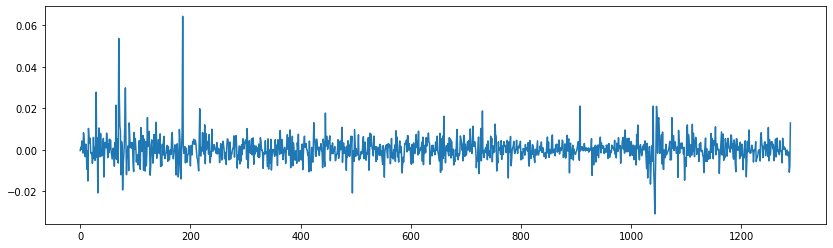

In [18]:


accumulative = np.array(accumulative)
fx_returns = accumulative[1:] / accumulative[0:len(accumulative) - 1] - 1
sharpe = (fx_returns.mean()) / np.std(fx_returns) * np.sqrt(365)
print(sharpe)
plt.plot(fx_returns)
plt.show()

In [19]:
cm = pd.read_csv('result.csv')
a = np.array(cm['value'])
print('Total trading days:', len(a))


Total trading days: 1202


In [20]:
cmd = list(pd.read_csv('result_position.csv')['date'])

for i in range(len(cmd)):
    y,m,d = cmd[i].split('-')[0], cmd[i].split('-')[1], cmd[i].split('-')[2]
    if float(m) < 10:
        m = m[-1]
    if float(d) < 10:
        d = d[-1]
    cmd[i] = '{}/{}/{}'.format(m, d, y)
    
        
print(cmd)

['3/22/2016', '3/23/2016', '3/24/2016', '3/25/2016', '3/28/2016', '3/29/2016', '3/30/2016', '3/31/2016', '4/1/2016', '4/5/2016', '4/6/2016', '4/7/2016', '4/8/2016', '4/11/2016', '4/12/2016', '4/13/2016', '4/14/2016', '4/15/2016', '4/18/2016', '4/19/2016', '4/20/2016', '4/21/2016', '4/22/2016', '4/25/2016', '4/26/2016', '4/27/2016', '4/28/2016', '4/29/2016', '5/3/2016', '5/4/2016', '5/5/2016', '5/6/2016', '5/9/2016', '5/10/2016', '5/11/2016', '5/12/2016', '5/13/2016', '5/16/2016', '5/17/2016', '5/18/2016', '5/19/2016', '5/20/2016', '5/23/2016', '5/24/2016', '5/25/2016', '5/26/2016', '5/27/2016', '5/30/2016', '5/31/2016', '6/1/2016', '6/2/2016', '6/3/2016', '6/6/2016', '6/7/2016', '6/8/2016', '6/13/2016', '6/14/2016', '6/15/2016', '6/16/2016', '6/17/2016', '6/20/2016', '6/21/2016', '6/22/2016', '6/23/2016', '6/24/2016', '6/27/2016', '6/28/2016', '6/29/2016', '6/30/2016', '7/1/2016', '7/4/2016', '7/5/2016', '7/6/2016', '7/7/2016', '7/8/2016', '7/11/2016', '7/12/2016', '7/13/2016', '7/14/2

In [517]:
temp_day

'3/22/2016'

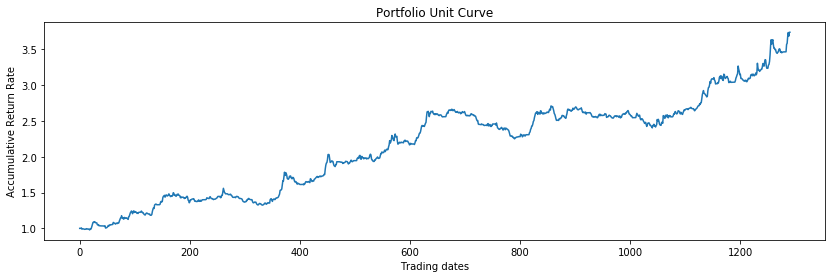

In [22]:
modified = {}
for i in range(len(trading_days)):
    temp_day = trading_days[i]
    if temp_day in cmd:
        modified[i] = a[cmd.index(temp_day)] * (1 + 0.03/252)**2
    else:
        modified[i] = 0
modified[0] = 100000000
modified[1] = modified[0] * (1 + 0.03 / 252)
for k,v in modified.items():
    if v == 0:
        modified[k] = modified[k-1] * (1 + 0.03 / 365)
cm_pnl = [v for k, v in modified.items()]
cm_pnl = np.array(cm_pnl)
plt.title('Portfolio Unit Curve')
plt.xlabel("Trading dates")
plt.ylabel('Accumulative Return Rate')
plt.rcParams['figure.figsize'] = (14.0, 4.0)
plt.plot((np.array(cm_pnl)-1) / cm_pnl[0])
plt.show()

In [46]:
# RISK PARITY ON WEEKLY BASIS


cm_returns = cm_pnl[1:] / cm_pnl[0:len(cm_pnl) -1] - 1
fx_returns = fx_pnl[1:] / cm_pnl[0:len(fx_pnl) -1]-1
dr_returns = dr_pnl[1:] / dr_pnl[0:len(fx_pnl) -1]-1

fx_stds, cm_stds = {}, {}
for k in range(5,len(fx_returns)):
    prev_rets = fx_returns[k-5:k]
    fx_stds[k] = np.std(prev_rets) * np.sqrt(52)

for k in range(5,len(cm_returns)):
    prev_rets = cm_returns[k-5:k]
    cm_stds[k] = np.std(prev_rets )* np.sqrt(52)
    if cm_stds[k] == 0:
        cm_stds[k] = cm_stds[k-1]
        

    
for k in fx_stds:
    print(fx_stds[k], '|', cm_stds[k])
    if fx_stds[k] > cm_stds[k]:
        print('?')

[ 1.19047619e-04  1.19047619e-04  6.72069900e-03 ... -1.35087449e-02
  1.48125026e-02  8.21917808e-05]
0.012809370053405019 | 0.06300273645262476
0.015141342028384217 | 0.06285509053939671
0.02444851706908994 | 0.06267532851496141
0.023110137917458733 | 0.055045622028806335
0.02687370594772214 | 0.020235379090065352
?
0.03200074910595354 | 0.012214494962777253
?
0.029934808064386344 | 0.012679519196330319
?
0.021566042923893504 | 0.026918622643420105
0.030732535213636756 | 0.02739276345972889
?
0.03091079226569828 | 0.025415046931410796
?
0.049700835714384536 | 0.029958460926468946
?
0.06342630288662209 | 0.03056387327598839
?
0.06656857718825542 | 0.01974730751075051
?
0.06166185910823326 | 0.02828506499275442
?
0.06305461445324592 | 0.057430895936385395
?
0.02748368041289844 | 0.058470713483062715
0.02288799540889922 | 0.07279941121648381
0.021841765213727413 | 0.09160571726980687
0.02798836540001081 | 0.0853223147435182
0.014537350725282143 | 0.08892941341565713
0.03035378758567567 

0.03211200920582904 | 0.06087080828447619
0.045928230691808763 | 0.05473076185081194
0.04362710039853229 | 0.07316134075035988
0.0448506809985201 | 0.07824865684063026
0.050960030667308816 | 0.045924691697916624
?
0.03908589652869946 | 0.06359635563834348
0.03880050769383516 | 0.0579105086577387
0.03751857492686787 | 0.05205405476740018
0.037122203021353176 | 0.07118631212240545
0.02822725463436688 | 0.0718235378655378
0.022173925557540972 | 0.05614126778177303
0.015719122669532185 | 0.055869251730390035
0.017728764375782115 | 0.05775060545664468
0.02547933206498742 | 0.04139580695886181
0.02338561200660761 | 0.05639746793897981
0.033218238075610876 | 0.052949210024293966
0.03825206402170162 | 0.054723600042279184
0.033637799192059684 | 0.04548767552680007
0.03209458952549093 | 0.04010775063983519
0.03185660604942904 | 0.019389682105292443
?
0.015168321535177493 | 0.01466897614007007
?
0.015642506521595385 | 0.013396908896115462
?
0.01834634848594273 | 0.012132981593836243
?
0.03220524

0.017202986330858438 | 0.04321917473212169
0.013408634533835069 | 0.031187824148826246
0.018603246161327306 | 0.028486584480669472
0.021117620925433588 | 0.026318561679965533
0.02424092652854853 | 0.028577425240944813
0.02386113968659782 | 0.025828125182212024
0.02210907401676501 | 0.0297965185387929
0.01847323836946772 | 0.035272241972935534
0.017454485805162675 | 0.04919448635356599
0.026369428174334 | 0.043738111725154905
0.025555100406874743 | 0.04344093181680574
0.025025626286654105 | 0.026316299804653984
0.024357668052889535 | 0.026066197339613868
0.03112153716837423 | 0.01018979371009484
?
0.025882329631581033 | 0.010157139418513391
?
0.02322556236084388 | 0.009429892404595621
?
0.022666915746386348 | 0.03340419891106313
0.020526878492251713 | 0.04972664605382515
0.027313485547766525 | 0.0509807114843663
0.02668740392411271 | 0.05938683758867193
0.02243251420039383 | 0.052630512909954234
0.02514638010823806 | 0.060448919131411497
0.030033306927022028 | 0.05285270666568156
0.0302

0.009917487889424224 | 0.06576960591901242
0.012351942086165364 | 0.06150045629921716
0.013176740439458932 | 0.07234750111986434
0.013348576873279753 | 0.07207050291683686
0.012778510732235899 | 0.0707011717301372
0.014004918252060752 | 0.03921592325323628
0.00985049245395637 | 0.03962496953160148
0.011135065458884312 | 0.02979668136393944
0.010815817325572005 | 0.030666997519392832
0.007518743344762092 | 0.02782421085985472
0.00851158360175383 | 0.023593258100654834
0.015682717514873785 | 0.015599674730254505
?
0.025357010153225154 | 0.014399217371032755
?
0.025500938315426186 | 0.01269011332480171
?
0.020847594293393414 | 0.014859168076097464
?
0.025681100398173652 | 0.01607910737704651
?
0.025615850835506108 | 0.03177190732104683
0.017440681125408555 | 0.03244678944488734
0.017710831541240438 | 0.03833327080966322
0.010087808319206462 | 0.06326213778255384
0.01893320280771765 | 0.06688661134378653
0.02646588196666918 | 0.07019436636391417
0.02798468171324531 | 0.0699208067033839
0.0

0.014768763505056326 | 0.1550015819839833
0.025486726977928607 | 0.06138667906229918
0.03482091508369942 | 0.03924054940568708
0.034175320089776445 | 0.026552014229353247
?
0.03337974537203309 | 0.026586024740306056
?
0.029379783513999235 | 0.025736453151508423
?
0.027693859586731148 | 0.0373985296564424
0.016932372110433157 | 0.04597392388253141
0.017801989105843248 | 0.0582922227522229
0.02008676621767867 | 0.06818494359152812
0.017847362238591034 | 0.06921606785455864
0.018141064102719137 | 0.06596250829024015
0.017891667116606332 | 0.10067142055856487
0.016533456807397585 | 0.10401011532603298
0.017460296573329603 | 0.0843412441433293
0.032655032888869104 | 0.06435384393031968
0.040003029518040474 | 0.08827608555240835
0.04147182720567015 | 0.05720616742670129
0.043361609601929814 | 0.04410458931596773
0.04241067896934502 | 0.07070951275400245
0.02847824890348099 | 0.09329868915739725
0.022938361394342483 | 0.09092596723358021
0.02135059389371544 | 0.13631760196094403
0.01682869495

In [47]:
fs = [v for k, v in fx_stds.items()]
cs = [v for k, v in cm_stds.items()]
for j in range(4, -1, -1):
    fs = [np.mean(fs[:5])] + fs
    cs = [np.mean(cs[:5])] + cs


In [48]:
news = []
fx_value = np.array(accumulative) - 100000000
wgs= []
for j in range(1290):
    x = 1/ (1 + fs[j] / cs[j])
    print(x)
    wgs.append(x)
    news.append(x* fx_value[j] + (1-x) * cm_pnl[j])
news = 100000000 + np.array(news)

0.7698707435098379
0.7759636676287295
0.7655010650541763
0.7553422599178732
0.7204154899910762
0.8310379351827373
0.8058713516771938
0.7193820256074025
0.7043066572016216
0.4295430292019893
0.276250764188711
0.2975412264226621
0.5551986866042765
0.47127092823491823
0.45121470525227836
0.376082418371551
0.32518157241359413
0.22877952974254728
0.3144639494397544
0.47666226213146173
0.6802527576872385
0.7608045173749363
0.8074724556633726
0.7529944629706719
0.8594973869533621
0.6602843310100465
0.748582292060366
0.7299903913964095
0.7234934490002641
0.638053542611215
0.361386623602993
0.3574892102231224
0.42486627673413957
0.36219199687167236
0.3923739204837597
0.5008239133607358
0.5076496428206883
0.40934800726677995
0.5619508387082689
0.5337819765079524
0.2661460515012654
0.2063952979964481
0.10552406483001363
0.06373913436121909
0.09469177440144826
0.21534211371452427
0.38091039377673
0.6600004497151006
0.6930334428332249
0.7881166253361476
0.8551134038472478
0.7927021326889976
0.58270

0.5314408866477957
0.5279466636962136
0.4202653287032089
0.3794421486309766
0.3039540284455157
0.307863613385503
0.41768139417225075
0.4083943971229647
0.36972155612072294
0.34160591881148855
0.3239166869599689
0.38627778992807615
0.30847412212377484
0.27579947760340945
0.5101431285740134
0.6201675024850566
0.624910399738539
0.6911305089727584
0.6978466521876716
0.5673548783914311
0.5676605784997993
0.5452748687612053
0.7012096625215205
0.5838966839683061
0.5244920086738908
0.6911945445081841
0.7311787436586648
0.7446948822137874
0.8466290169686944
0.8248229578690307
0.7907861746760393
0.8010548482964215
0.8058012037869876
0.8484994051158773
0.8849252415025612
0.8753568457852539
0.8073825703289648
0.717035461149744
0.6745668663438126
0.6327544337625701
0.35316377407040644
0.34378717082654436
0.29799999458329895
0.33585789479637573
0.4132139385349381
0.623537925450231
0.6791663970252125
0.6470473151782762
0.7812948295577914
0.7581287713239757
0.7667509504803811
0.46439370886409775
0.478

In [49]:
pf = news[1:] - news[:len(news) - 1]

In [50]:
zr = fx_value[1:] - fx_value[0:len(fx_value) - 1]
cmr = cm_pnl[1:] - cm_pnl[0:len(cm_pnl) - 1]
for i in range(len(pf)):
    print(pf[i], zr[i], cmr[i])

-631704.9399608672 -32320.620555907488 11904.761904761195
1142976.1397316605 122091.51314781606 11906.179138302803
1196794.6574374884 22662.525928154588 672229.9261676669
3316598.2015563995 427098.9454199374 -1803215.1002735049
-10519890.307801098 336390.34214119613 477257.22238367796
2337662.901656583 -156078.50157220662 -78913.72562764585
9099177.72946173 829624.3069662899 -81985.33683308959
1765529.5387835056 554835.2412056327 -329736.2146053463
26427587.252982855 -91515.2144832164 -216304.97198863328
14848731.327825189 -329750.37047179043 171431.4897337705
-1978734.1094819307 282181.5809928179 8123.389662757516
-24558092.317774832 147206.7657584995 722532.8850565553
7540028.316371173 -951377.8177413195 -360506.67959848046
2000268.6928901076 -43593.8297021091 97584.72030885518
6537637.546694249 -1516893.4354518652 -430726.91571722925
5532739.94087702 1027586.0984600186 215775.03583587706
9314046.615266383 506162.2466814965 -380464.2605550736
-8842815.921161503 329989.8754337579 -855

17057570.005510896 580644.215074718 0.0
55039.782613784075 -490724.47098869085 0.0
-268496.00028946996 -253028.80554822087 0.0
127019678.42951268 -19106.68435755372 0.0
-32157178.136176497 510837.70238405466 -386336.8685454428
-8582375.808460474 19149.34121762216 82592.86145600677
-23438735.98271379 97154.83390502632 -501664.82267951965
18714883.880059153 1298554.8858381659 251200.39894020557
7049317.6617049575 -726888.9009572864 -401260.0210425854
-26395513.087484807 -29702.82820738852 -1490519.6222619414
-14090346.217122853 400545.6375697553 1162705.0851171613
1547656.56228441 -206530.15709345043 -314489.7651464939
-25587339.54316479 170967.41351500154 486398.38846322894
-20762999.823957413 -146012.06208477914 369723.91378620267
16476537.044216603 -65824.40851595998 1343622.753061533
31141614.14954245 -1186942.6019303203 -187630.06584900618
5936831.890139818 214609.787437886 -173707.45153266191
-4696129.676359415 -409378.183420524 -87205.95961657166
-8499434.3768754 522126.5714879036

-4663209.586142063 -186435.30306088924 275805.35621741414
-5831601.07902205 -475497.69069834054 1823370.2582638264
19440834.66692847 818944.4558708519 -1417278.6870575547
-1755069.160760045 257582.8030435145 -1461397.7897302806
17089037.66683978 688077.744961977 1577308.3825630844
10250899.297322512 -721055.0519927591 -395069.947478652
-10272993.001965344 249395.75479708612 2269071.3586265445
-63808.54337280989 -165711.56204260886 20183.897078365088
13248599.634482622 29358.931551620364 20185.556028813124
-15598520.570307404 -122833.26945361495 20187.215115606785
41497115.92428744 1552974.4610596448 20188.874338775873
2816407.9453861415 836868.7654399425 20190.533698290586
12522042.09310186 838357.7995197922 -1575803.072371453
-17793782.5864895 -1304976.291214645 2955851.0484051406
-19711525.483174115 -428198.827798903 -3477475.8226055503
-17204208.809017986 -792666.415138483 -3243997.3424164653
-3513577.0662489235 484684.46122680604 -645992.9803911448
-12755764.823092818 -16559.906238

8165959.200565606 3404.075297564268 -1188767.4893436134
12763127.44595626 334975.94224506617 -1870620.5063142478
-13703631.244507939 4704.753443241119 -1028960.346817404
32925622.510376245 590925.4590565562 -2074950.6476617754
-23277529.17354375 263278.47821342945 716108.4715750813
12764167.67908907 -496851.7265534997 821111.367800951
13037719.250796348 -1226583.979106307 -3232003.187175095
-1213665.7379978597 427033.2865611017 -2507367.4856696427
2741371.0807607174 -1833441.1741296053 1900717.070883572
-11198331.598787993 -146819.82925963402 2660338.1007418633
198683.23900833726 -860158.5370010436 -225337.94231188297
15249616.650831401 202010.20499567688 723439.0166313648
2815455.904790044 -600830.1466344595 -1315516.4622823894
-1463506.2739949226 -2182170.4265961796 -2240777.2231304348
22528369.748054594 -1121061.6319745183 10712.75019940734
8262572.483819991 249841.94466340542 -959531.719143182
15363013.718024671 88879.6264026314 -1116588.8070113957
-2053627.5279761553 -704700.64295

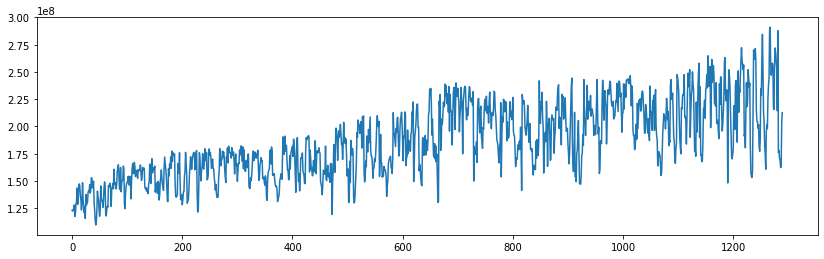

In [35]:
plt.plot(news)

In [51]:
final_port_return[-1]

2.1497249302987083

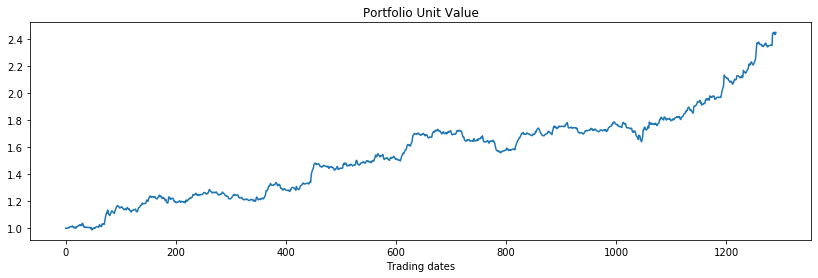

In [52]:
len(wgs)
all_pnls = [wgs[i] * zr[i] + (1-wgs[i]) * cmr[i] for i in range(len(wgs))]
aaaa = np.array([np.sum(all_pnls[:i+1]) for i in range(len(wgs))])

final_port_return = (aaaa + 100000000) / 100000000
final_port_return = np.append([1], final_port_return)
plt.plot(final_port_return)

plt.title('Portfolio Unit Value')

plt.xlabel('Trading dates')

plt.show()

pd.DataFrame({'Unit Value': final_port_return}).to_csv('final results.csv', index=False, header=True)

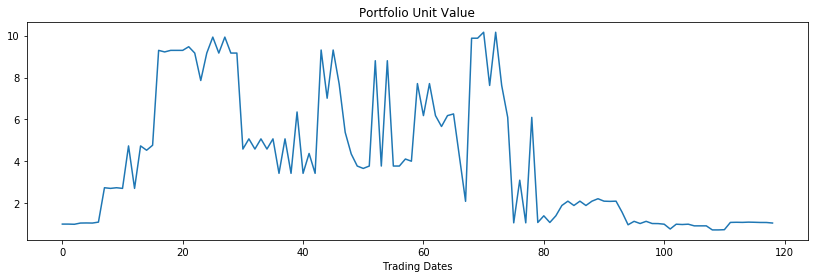

In [38]:
wtf = pd.read_csv('options.csv')
s = np.array(wtf['Unnamed: 2'])
plt.title('Portfolio Unit Value')

plt.xlabel('Trading Dates')
plt.plot(s)
plt.show()

In [660]:
apa = final_port_return[1:]/final_port_return[:len(final_port_return)-1] -1
(np.mean(apa) -0.029 / 252) /np.std(apa)*np.sqrt(252)

1.4657140192478733